# Preview: Incrementally applying safeguards for tighter and less conservative corrections

The `compression-safeguards` are implemented to use one-shot (instead of iterative) algorithms and to make use of vectorisation over arrays. As a consequence, the corrections for all elements are computed simultaneously. While this makes no difference for pointwise safeguards, it means that stencil safeguards have to make conservative assumptions about how neighbouring elements can affect each other in order to guarantee that their combined errors do not violate any user safety requirements. Incrementally applying the safeguards allows making less conservative assumptions and producing tighter corrections by giving the safeguards knowledge of previously corrected elements when computing the corrections for the next elements. While the `compression-safeguards` API currently does not provide support for incrementally computing corrections, this notebook sketches incrementally applying the safeguards might work, by extending and patching the package where necessary.

For this example, we use a quantity of interest safeguard that preserves the box mean over five elements (two before, two after) along the latitude axis of a U-wind field. (In the default one-shot safeguards implementation, guaranteeing an absolute error bound on the unweighted box mean is equivalent to guaranteeing the same error bound pointwise, i.e. the safeguards do not exploit that in a box mean some elements can tolerate a higher error if others compress with a lower error). We then test a simple high-level implementation for incremental safeguards, where we partition all data points into $K$ non-overlapping groups and then apply the safeguards $K$ times, each round giving the safeguards access to the already-corrected values from prior rounds and only keeping the corrections for this round's subset of data points. For this simple approach, we compare two variants. For the first, we randomly partition the data points into $K=5$ groups, for the second we select the groups based on the box-mean's five element stencil by stepping over the latitude axis in steps of $5$ and putting the first element in the first group, second element in the second group, etc. Finally, we compare both approaches for two different predictions of the data that the safeguards produce corrections for: an all-zero prediction that requires corrections for most elements, and a prediction from the lossy SPERR compressor that has been configured with a RMSE error bound that exceeds the conservative pointwise absolute error bound for many but not all points.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import re
from collections.abc import Collection, Mapping, Set
from itertools import product
from pathlib import Path
from typing import ClassVar

import earthkit.plots
import matplotlib as mpl
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numcodecs_safeguards.lossless import Lossless
from typing_extensions import override

from compression_safeguards import SafeguardKind, Safeguards
from compression_safeguards.safeguards._qois import StencilQuantityOfInterest
from compression_safeguards.safeguards._qois.expr.typing import F, Ns, Ps
from compression_safeguards.safeguards.abc import Safeguard
from compression_safeguards.safeguards.pointwise.abc import PointwiseSafeguard
from compression_safeguards.safeguards.stencil.qoi.eb import (
    StencilQuantityOfInterestErrorBoundSafeguard,
)
from compression_safeguards.utils.bindings import Bindings, Parameter
from compression_safeguards.utils.intervals import Interval, IntervalUnion, Lower, Upper
from compression_safeguards.utils.typing import JSON, C, S, T

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00")
ERA5_U.shape

(1, 721, 1440)

In [4]:
qoi = SafeguardKind.qoi_eb_stencil.value(
    qoi="sum(X) / size(X)",  # box mean along the latitude axis
    neighbourhood=[
        dict(axis=1, before=2, after=2, boundary="reflect"),
    ],
    type="abs",
    eb=0.1,  # 0.1 m/s absolute error bound on the box mean
)
qoi._qoi_expr

(X[0] + X[1] + X[2] + X[3] + X[4]) / 5

In [5]:
def compute_mean_wind_u(ERA5_U: xr.DataArray) -> xr.DataArray:
    ERA5_U_mean = ERA5_U.copy(
        data=qoi.evaluate_qoi(ERA5_U.values, late_bound=Bindings.empty())
    )
    ERA5_U_mean.attrs.update(long_name=f"mean {ERA5_U.long_name}")
    return ERA5_U_mean

In [6]:
ERA5_U_mean = compute_mean_wind_u(ERA5_U)

In [7]:
# for computing compression ratios, we use the default lossless codec for
#  safeguards corrections from the numcodecs-safeguards package
correction_codec = Lossless().for_safeguards
correction_codec

CodecStack(PickBestCodec(HuffmanCodec(), CodecStack(BinaryDeltaCodec(), HuffmanCodec())), Zstd(level=3))

In [8]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [9]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [10]:
def plot_mean_wind_u(
    my_ERA5_U: xr.DataArray,
    chart,
    title,
    span,
    mean=True,
    error=False,
    qoi_stencil=None,
    incremental_masks=None,
    correction=None,
    extra_bytes=0,
):
    import copy

    ERA5_U_pick = ERA5_U_mean if mean else ERA5_U
    my_ERA5_U_pick = compute_mean_wind_u(my_ERA5_U) if mean else my_ERA5_U

    if error:
        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_U_pick - ERA5_U_pick).compute()

        err_U_pick = np.amax(np.abs(my_ERA5_U_pick - ERA5_U_pick))

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_U_pick

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(-span, span, 22))
    style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
    style._colors = "coolwarm" if error else style._colors

    extend_left = np.nanmin(da) < -span
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        overline_start = r"\overline{{{{" if mean else ""
        overline_end = "}}}}" if mean else ""
        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}({overline_start}\hat{{{{u}}}}{overline_end})$={err_U_pick:.02}"
        )
    else:
        chart.title(f"{title}\n")

    if correction is not None:
        encoded = correction_codec.encode(correction)
        cr = ERA5_U.nbytes / (np.array(encoded).nbytes + extra_bytes)

    if error and mean:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

    if not mean:
        old_process_projection_requirements = (
            chart.ax.get_figure()._process_projection_requirements
        )

        def _process_projection_requirements(
            *, axes_class=None, polar=False, projection=None, **kwargs
        ):
            if axes_class is not None and projection is not None:
                return axes_class, dict(projection=projection, **kwargs)
            return old_process_projection_requirements(
                axes_class=axes_class, polar=polar, projection=projection, **kwargs
            )

        chart.ax.get_figure()._process_projection_requirements = (
            _process_projection_requirements
        )

        axin = chart.ax.inset_axes(
            [0.75, 0.5, 0.225, 0.45],
            xlim=(-0.5 * 7.5, 0.5 * 7.5),
            ylim=(50 - 0.5 * 7.5, 50 + 0.5 * 7.5),
            xticklabels=[],
            yticklabels=[],
            axes_class=type(chart.ax),
            projection=chart.ax.projection,
        )
        axin.pcolormesh(
            da.longitude.values,
            da.latitude.values,
            np.squeeze(da.values),
            cmap=chart.ax.collections[0].colorbar.cmap,
            rasterized=True,
        )
        axin.coastlines(color="#555555")
        axin.spines["geo"].set_edgecolor("black")
        inset_indicator = chart.ax.indicate_inset_zoom(axin, edgecolor="black", alpha=1)
        inset_indicator.connectors[1].set_visible(True)
        inset_indicator.connectors[3].set_visible(False)

    counts, bins = np.histogram(da.values.flatten(), range=(-span, span), bins=21)
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    cax = cb.ax.inset_axes(
        [
            0.0,
            1.25 if (qoi_stencil is None and incremental_masks is None) else 3.5,
            1.0,
            1.0,
        ]
    )
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
    )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(-span, span)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

    stackcolors = np.array(mpl.color_sequences["Pastel1"])[[2, 3, 4, 0, 1, 6, 7]]

    if (qoi_stencil is not None) or (incremental_masks is not None):
        assert (qoi_stencil is None) or (incremental_masks is None)
        cax2 = cb.ax.inset_axes([0.0, 1.25, 1.0, 2.0])
        counts_stacked = []
        if qoi_stencil is not None:
            for i in product(*[range(s) for s in qoi_stencil]):
                incrindex = tuple(
                    slice(None) if s == 1 else slice(j, None, s)
                    for j, s in zip(i, qoi_stencil)
                )
                counts2, _bins2 = np.histogram(
                    da.values[incrindex].flatten(), range=(-span, span), bins=21
                )
                counts_stacked.append(counts2)
        else:
            for next_incremental_mask in incremental_masks:
                counts2, _bins2 = np.histogram(
                    da.values.flatten()[next_incremental_mask.flatten()],
                    range=(-span, span),
                    bins=21,
                )
                counts_stacked.append(counts2)
        counts_stacked = np.stack(counts_stacked, axis=0)
        counts_stacked = counts_stacked / np.sum(counts_stacked, axis=0)
        for i in range(len(counts_stacked)):
            cax2.bar(
                midpoints,
                counts_stacked[i],
                bottom=counts_stacked[:i].sum(0),
                width=(bins[-1] - bins[0]) / len(counts),
                color=stackcolors[i],
            )
        cax2.set_xlim(-span, span)
        cax2.set_xticks([])
        cax2.set_yticks([])
        cax2.spines[:].set_visible(False)

        if error and not mean:
            legend_elements = []
            qoi_stencil_indices = (
                list(product(*[range(s) for s in qoi_stencil]))
                if qoi_stencil is not None
                else incremental_masks
            )
            for k, i in enumerate(qoi_stencil_indices):
                if len(qoi_stencil_indices) != 1:
                    if qoi_stencil is not None:
                        incrindex = (
                            tuple(
                                slice(None) if s == 1 else slice(j, None, s)
                                for j, s in zip(i, qoi_stencil)
                            )
                            if qoi_stencil is not None
                            else i
                        )
                        correction_encoded = correction_codec.encode(
                            np.ascontiguousarray(correction[incrindex])
                        )
                        correction_cr = ERA5_U[incrindex].nbytes / (
                            np.array(correction_encoded).nbytes
                            + extra_bytes * ERA5_U[incrindex].size / ERA5_U.size
                        )
                        corrections = np.mean(correction[incrindex] != 0)
                    else:
                        # the correction codec doesn't care about the shape, so
                        #  even values in random order produce the "right"
                        #  encoding
                        correction_encoded = correction_codec.encode(correction[i])
                        correction_cr = ERA5_U.data[i].nbytes / (
                            np.array(correction_encoded).nbytes
                            + extra_bytes * ERA5_U.data[i].size / ERA5_U.size
                        )
                        corrections = np.mean(correction.flatten()[i.flatten()] != 0)
                legend_elements.append(
                    Patch(
                        facecolor=stackcolors[k],
                        edgecolor="grey",
                        label=(
                            f"one-shot: x {np.round(cr, 2)} "
                            f"({np.round(np.mean(correction != 0) * 100, 2)}%)"
                        )
                        if len(qoi_stencil_indices) == 1
                        else (
                            f"#{k + 1}: x {np.round(correction_cr, 2)} "
                            f"({np.round(corrections * 100, 2)}%)"
                        ),
                    )
                )
            chart.ax.legend(handles=legend_elements, loc="lower center", ncol=2)

## Predicting u with lossy compressors

In [11]:
from numcodecs_zero import ZeroCodec

zero = ZeroCodec()

ERA5_U_zero_encoded = zero.encode(ERA5_U.values)
ERA5_U_zero_prediction = zero.decode(ERA5_U_zero_encoded)
ERA5_U_zero_check = np.mean(
    ~qoi.check_pointwise(
        ERA5_U.values, ERA5_U_zero_prediction, late_bound=Bindings.empty()
    )
)

In [12]:
from numcodecs_wasm_sperr import Sperr

# PSNR is chosen such that the RMSE is approximately 0.1
sperr = Sperr(mode="psnr", psnr=49.875)

ERA5_U_sperr_encoded = sperr.encode(ERA5_U.values)
ERA5_U_sperr_prediction = sperr.decode(ERA5_U_sperr_encoded)
ERA5_U_sperr_check = np.mean(
    ~qoi.check_pointwise(
        ERA5_U.values, ERA5_U_sperr_prediction, late_bound=Bindings.empty()
    )
)

print(
    f"RMSE(SPERR) = {np.sqrt(np.mean((ERA5_U_sperr_prediction - ERA5_U.values).flatten() ** 2))}"
)

RMSE(SPERR) = 0.10017840564250946


## Computing the one-shot safeguards corrections

In [13]:
sg = Safeguards(safeguards=[qoi])

In [14]:
ERA5_U_sg_correction = sg.compute_correction(ERA5_U.values, ERA5_U_zero_prediction)
ERA5_U_sg = sg.apply_correction(ERA5_U_zero_prediction, ERA5_U_sg_correction)

assert sg.check(ERA5_U.values, ERA5_U_sg)

## Computing the incremental safeguards corrections

In [15]:
INCREMENTAL_MASK: Parameter = Parameter("$incrmask")
INCREMENTAL_PREDICTION: Parameter = Parameter("$incrpred")


class IncrementalSafeguard(PointwiseSafeguard):
    __slots__: tuple[str, ...] = ()

    kind: ClassVar[str] = "incremental"

    def __init__(self) -> None:
        pass

    @property
    @override
    def late_bound(self) -> Set[Parameter]:
        return frozenset([INCREMENTAL_MASK, INCREMENTAL_PREDICTION])

    @override
    def check_pointwise(
        self,
        data: np.ndarray[S, np.dtype[T]],
        decoded: np.ndarray[S, np.dtype[T]],
        *,
        late_bound: Bindings,
    ) -> np.ndarray[S, np.dtype[np.bool]]:
        return np.ones_like(data, dtype=np.bool)  # type: ignore

    @override
    def compute_safe_intervals(
        self,
        data: np.ndarray[S, np.dtype[T]],
        *,
        late_bound: Bindings,
    ) -> IntervalUnion[T, int, int]:
        mask = late_bound.resolve_ndarray_with_lossless_cast(
            INCREMENTAL_MASK, data.shape, np.dtype(np.bool)
        )
        prediction = late_bound.resolve_ndarray_with_lossless_cast(
            INCREMENTAL_PREDICTION, data.shape, data.dtype
        )

        valid = Interval.full_like(data)
        Lower(prediction.flatten()) <= valid[mask.flatten()] <= Upper(
            prediction.flatten()
        )

        validu = valid.into_union()

        # override the class of the valid interval union with one that accepts
        #  non-overlap with the data for elements that have already been
        #  corrected,
        # which is required to create a safeguard that forces the existing
        #  corrections to be recreated
        class IncrementalIntervalUnion(IntervalUnion):
            __slots__ = ()

            def contains(
                self, other: np.ndarray[S, np.dtype[T]]
            ) -> np.ndarray[S, np.dtype[np.bool]]:
                is_contained: np.ndarray[S, np.dtype[np.bool]] = super().contains(other)

                if np.array_equal(other, data, equal_nan=True):
                    is_contained |= mask

                return is_contained

        validu.__class__ = IncrementalIntervalUnion

        return validu

    @override
    def get_config(self) -> dict[str, JSON]:
        return dict(kind=type(self).kind)

In [16]:
def rewrite_stencil_qoi_eb_safeguard_into_incremental(
    qoi: StencilQuantityOfInterestErrorBoundSafeguard,
) -> Collection[Safeguard]:
    # extract the fully-resolved QoI expression, in text representation
    qoi_expr_repr = repr(qoi._qoi_expr)

    # replace mentions of the data stencil X with where(mask, prediction, X)
    #  to fill in the already-corrected prediction as a constant for elements
    #   where the correction has already been produced
    qoi_expr_incremental_repr = re.sub(
        r"X\[([^]]+)\]",
        rf'where(C["{INCREMENTAL_MASK}"][\1], C["{INCREMENTAL_PREDICTION}"][\1], X[\1])',
        qoi_expr_repr,
    )

    # create a new QoI expression with the incremental QoI
    qoi_incremental_expr = StencilQuantityOfInterestErrorBoundSafeguard(
        qoi=qoi_expr_incremental_repr,
        **{k: v for k, v in qoi.get_config().items() if k not in ("kind", "qoi")},
    )._qoi_expr

    # override (a copy of) the QoI's class with one that uses the incremental
    #  QoI, but only for deriving corrections, and thus requires the additional
    #  late-bound constants for incremental corrections
    class IncrementalStencilQuantityOfInterest(StencilQuantityOfInterest):
        __slots__ = ()

        @property
        def late_bound_constants(self) -> Set[Parameter]:
            return qoi_incremental_expr.late_bound_constants

        @np.errstate(divide="ignore", over="ignore", under="ignore", invalid="ignore")
        def compute_data_bounds(
            self,
            qoi_lower: np.ndarray[Ps, np.dtype[F]],
            qoi_upper: np.ndarray[Ps, np.dtype[F]],
            Xs: np.ndarray[Ns, np.dtype[F]],
            late_bound: Mapping[Parameter, np.ndarray[Ns, np.dtype[F]]],
        ) -> tuple[np.ndarray[Ns, np.dtype[F]], np.ndarray[Ns, np.dtype[F]]]:
            return qoi_incremental_expr.compute_data_bounds(
                qoi_lower, qoi_upper, Xs, late_bound
            )

    qoi_incremental = StencilQuantityOfInterestErrorBoundSafeguard(
        **{k: v for k, v in qoi.get_config().items() if k not in ("kind",)}
    )
    qoi_incremental._qoi_expr.__class__ = IncrementalStencilQuantityOfInterest

    # combine the incremental safeguard, which takes care of recreating already
    #  computed corrections, with the now-incremental QoI, which takes these
    #  already computed corrections into account to produce tighter corrections
    return (IncrementalSafeguard(), qoi_incremental)


sg_incremental = Safeguards(
    safeguards=[*rewrite_stencil_qoi_eb_safeguard_into_incremental(qoi)]
)

In [17]:
# compute the total stencil size over which we can incrementally apply the
#  safeguards
qoi_stencil = []

for axis in qoi.compute_check_neighbourhood_for_data_shape(ERA5_U.shape):
    max_stencil = 1

    for b, s in axis.items():
        max_stencil = max(max_stencil, s.before + 1 + s.after)

    qoi_stencil.append(max_stencil)

qoi_stencil

[1, 5, 1]

In [18]:
# create stepby masks using array slices with steps
# instead of applying the safeguards incrementally one element at a time,
# apply them to the i'th element of non-overlapping windows of the same size as
#  the stencil
# this gives (asymptotically) the same extra knowledge when the stencil is
#  symmetric, but one element per axis less knowledge when it is asymmetric
stepby_incremental_masks = [
    tuple(slice(None) if s == 1 else slice(j, None, s) for j, s in zip(i, qoi_stencil))
    for i in product(*[range(s) for s in qoi_stencil])
]

In [19]:
rng = np.random.Generator(np.random.PCG64(seed=42))

# create pseudo-randomly shuffled masks that determine how the safeguards are
#  applied incrementally
# the number of masks is arbitrary (any number works), though setting it to the
#  size of the stencil makes sense as a default
shuffled_incremental_masks = [
    np.zeros(ERA5_U.size, dtype=np.bool) for _ in range(np.prod(qoi_stencil))
]

indices = rng.permutation(ERA5_U.size)

for i in range(len(shuffled_incremental_masks)):
    shuffled_incremental_masks[i][indices[i :: len(shuffled_incremental_masks)]] = True
    shuffled_incremental_masks[i] = shuffled_incremental_masks[i].reshape(ERA5_U.shape)

In [20]:
def compute_incremental_correction(
    data: np.ndarray[S, np.dtype[T]],
    prediction: np.ndarray[S, np.dtype[T]],
    incremental_masks: list[tuple[slice] | tuple[np.ndarray[S, np.dtype[np.bool]]]],
) -> np.ndarray[S, np.dtype[C]]:
    incremental_mask = np.zeros(data.shape, dtype=np.bool)
    incremental_correction = np.empty(
        data.shape, sg.correction_dtype_for_data(data.dtype)
    )
    incremental_prediction = np.empty_like(data)

    # instead of applying the safeguards incrementally one element at a time,
    # apply them to the several non-overlapping masks that partition the data
    for next_incremental_mask in incremental_masks:
        # compute and apply the correction
        incremental_correction_partial = sg_incremental.compute_correction(
            data,
            prediction,
            late_bound={
                # all boundary conditions work for the mask
                # - valid, edge, reflect, symmetric, and wrap work as expected
                # - for a constant zero boundary, the mask is False for
                #   boundary points even though the constant value there is
                #   known - while unfortunate this is more conservative and
                #   thus still produces the correct results
                # - for a constant non-zero boundary, the mask is True for
                #   boundary points and, since the constant boundary points
                #   are always known, this is correct
                INCREMENTAL_MASK: incremental_mask,
                # boundary conditions are applied as expected to the already-
                #  corrected prediction
                INCREMENTAL_PREDICTION: incremental_prediction,
            },
        )
        incremental_corrected_partial = sg_incremental.apply_correction(
            prediction, incremental_correction_partial
        )

        # save the correction and corrected elements for the part of the stencil
        #  that we are (re-)computing, then update the mask to reflect that these
        #  elements have now already been corrected
        incremental_correction[next_incremental_mask] = incremental_correction_partial[
            next_incremental_mask
        ]
        incremental_prediction[next_incremental_mask] = incremental_corrected_partial[
            next_incremental_mask
        ]
        incremental_mask[next_incremental_mask] = True

    return incremental_correction

In [21]:
ERA5_U_sg_incremental_correction = dict()
ERA5_U_sg_incremental = dict()

for name, ERA5_U_prediction in dict(
    zero=ERA5_U_zero_prediction, sperr=ERA5_U_sperr_prediction
).items():
    # apply the combined correction using the non-incremental safeguard
    ERA5_U_sg_incremental_correction[name] = compute_incremental_correction(
        ERA5_U.values,
        ERA5_U_prediction,
        stepby_incremental_masks,
    )
    ERA5_U_sg_incremental[name] = sg.apply_correction(
        ERA5_U_prediction, ERA5_U_sg_incremental_correction[name]
    )

    assert sg.check(ERA5_U.values, ERA5_U_sg_incremental[name])

    # apply the combined correction using the non-incremental safeguard
    ERA5_U_sg_incremental_correction[f"{name}-shuffled"] = (
        compute_incremental_correction(
            ERA5_U.values, ERA5_U_prediction, shuffled_incremental_masks
        )
    )
    ERA5_U_sg_incremental[f"{name}-shuffled"] = sg.apply_correction(
        ERA5_U_prediction, ERA5_U_sg_incremental_correction[f"{name}-shuffled"]
    )

    assert sg.check(ERA5_U.values, ERA5_U_sg_incremental[f"{name}-shuffled"])

## Visual comparison of the error distributions for the one-shot and incremental safeguards

We can see from the figures below that the incremental safeguards produce increasingly less-conservative corrections with each round. While less-conservative corrections have lower entropy and may thus be easier to compress, the largest benefit of incremental safeguards corrections comes from requiring fewer (non-zero) corrections (for decent predictions) with every round. Even though the stepby incremental predictions produce a clear stepby pattern in the error distribution, they produce fewer and thus better-compressible corrections than the shuffled masks.

Note: the per-round compression ratios are only directly comparable with the final compression ratio for the stepby method which maintains the same data structure (in contrast to the shuffled method that has random spacings in between the points in the per-round subset that can introduce additional entropy inside each round but not to the final combined correction).

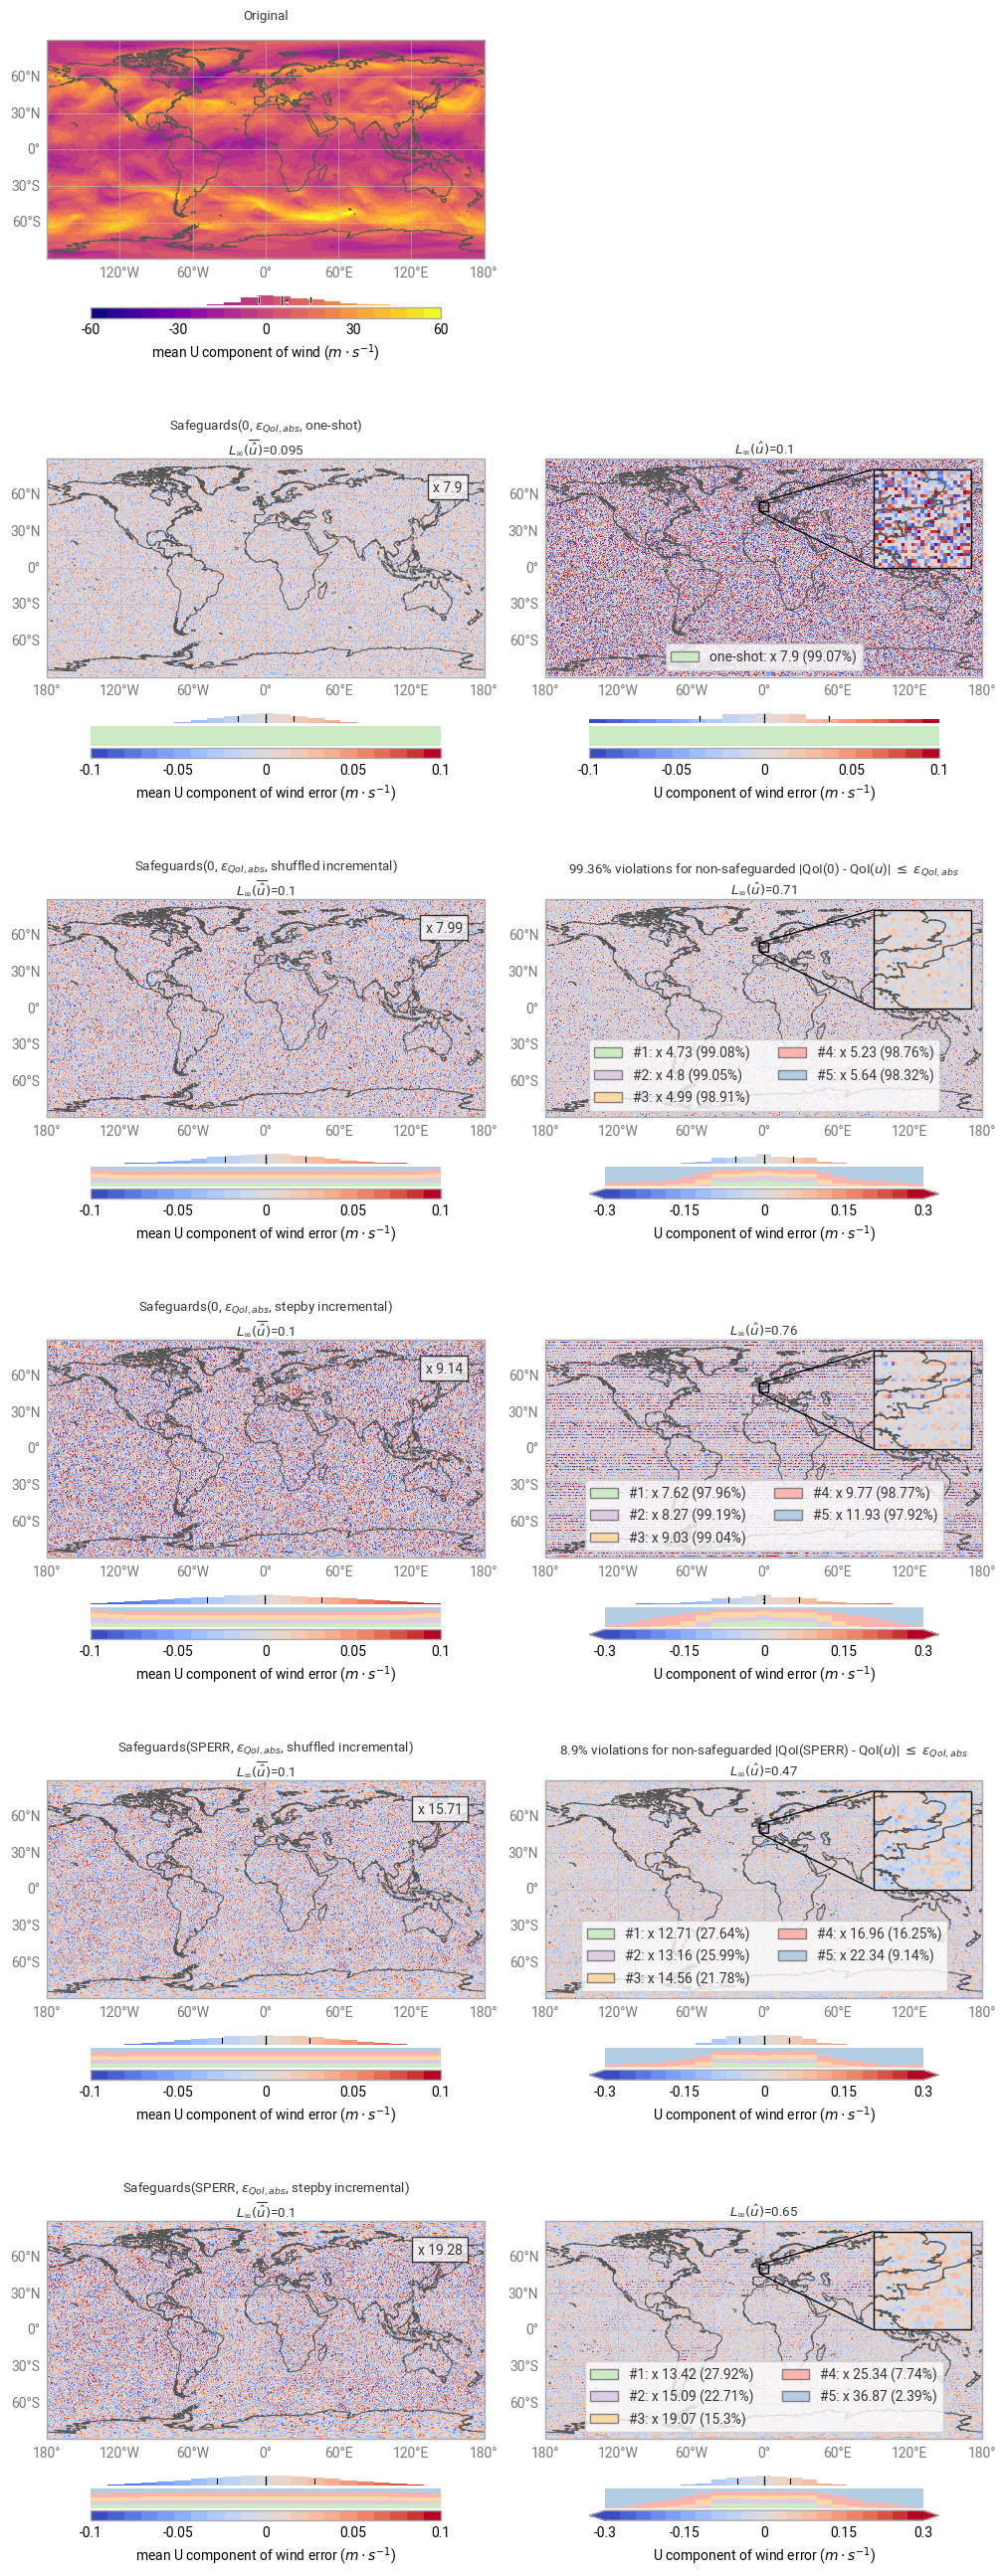

In [22]:
fig = earthkit.plots.Figure(
    size=(10, 26),
    rows=6,
    columns=2,
    hspace=0.1,
)

plot_mean_wind_u(ERA5_U, fig.add_map(0, 0), "Original", span=60)

plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg),
    fig.add_map(1, 0),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$, one-shot)",
    span=0.1,
    error=True,
    qoi_stencil=[1, 1, 1],
    correction=ERA5_U_sg_correction,
)
plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg),
    fig.add_map(1, 1),
    "",
    span=0.1,
    error=True,
    mean=False,
    qoi_stencil=[1, 1, 1],
    correction=ERA5_U_sg_correction,
)

plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["zero-shuffled"]),
    fig.add_map(2, 0),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$, shuffled incremental)",
    span=0.1,
    error=True,
    incremental_masks=shuffled_incremental_masks,
    correction=ERA5_U_sg_incremental_correction["zero-shuffled"],
    extra_bytes=np.array(ERA5_U_zero_encoded).nbytes,
)
plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["zero-shuffled"]),
    fig.add_map(2, 1),
    (
        f"{np.round(ERA5_U_zero_check * 100, 2)}% violations for non-safeguarded "
        rf"|QoI(0) - QoI($u$)| $\leq$ $\epsilon_{{{{QoI,abs}}}}$"
    ),
    span=0.3,
    error=True,
    mean=False,
    incremental_masks=shuffled_incremental_masks,
    correction=ERA5_U_sg_incremental_correction["zero-shuffled"],
    extra_bytes=np.array(ERA5_U_zero_encoded).nbytes,
)

plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["zero"]),
    fig.add_map(3, 0),
    r"Safeguards(0, $\epsilon_{{QoI,abs}}$, stepby incremental)",
    span=0.1,
    error=True,
    qoi_stencil=qoi_stencil,
    correction=ERA5_U_sg_incremental_correction["zero"],
    extra_bytes=np.array(ERA5_U_zero_encoded).nbytes,
)
plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["zero"]),
    fig.add_map(3, 1),
    "",
    span=0.3,
    error=True,
    mean=False,
    qoi_stencil=qoi_stencil,
    correction=ERA5_U_sg_incremental_correction["zero"],
    extra_bytes=np.array(ERA5_U_zero_encoded).nbytes,
)

plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["sperr-shuffled"]),
    fig.add_map(4, 0),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$, shuffled incremental)",
    span=0.1,
    error=True,
    incremental_masks=shuffled_incremental_masks,
    correction=ERA5_U_sg_incremental_correction["sperr-shuffled"],
    extra_bytes=ERA5_U_sperr_encoded.nbytes,
)
plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["sperr-shuffled"]),
    fig.add_map(4, 1),
    (
        f"{np.round(ERA5_U_sperr_check * 100, 2)}% violations for non-safeguarded "
        rf"|QoI(SPERR) - QoI($u$)| $\leq$ $\epsilon_{{{{QoI,abs}}}}$"
    ),
    span=0.3,
    error=True,
    mean=False,
    incremental_masks=shuffled_incremental_masks,
    correction=ERA5_U_sg_incremental_correction["sperr-shuffled"],
    extra_bytes=ERA5_U_sperr_encoded.nbytes,
)

plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["sperr"]),
    fig.add_map(5, 0),
    r"Safeguards(SPERR, $\epsilon_{{QoI,abs}}$, stepby incremental)",
    span=0.1,
    error=True,
    qoi_stencil=qoi_stencil,
    correction=ERA5_U_sg_incremental_correction["sperr"],
    extra_bytes=ERA5_U_sperr_encoded.nbytes,
)
plot_mean_wind_u(
    ERA5_U.copy(data=ERA5_U_sg_incremental["sperr"]),
    fig.add_map(5, 1),
    "",
    span=0.3,
    error=True,
    mean=False,
    qoi_stencil=qoi_stencil,
    correction=ERA5_U_sg_incremental_correction["sperr"],
    extra_bytes=ERA5_U_sperr_encoded.nbytes,
)

# manual fig.save to override the dpi
fig._release_queue()
plt.savefig("incremental.pdf", bbox_inches="tight", dpi=400)